# GNEU0001-1 - Tutorial 2 - Neural encoding modeling

## Instructions

- This homework must be carried out individually

- This homework is due by **November 25, 2022 at 10pm**.


## Gradescope submission

Submission must be done on the [Gradescope](https://www.gradescope.com/) platform directly.

- Each student must register on [Gradescope](https://www.gradescope.com/) using his address `@student.uliege.be`. If you don't see the GNEU0001 course in your dashboard, contact us as soon as possible (don't wait until the day before the submission date to check that you have access to the course on Gradescope ;-).

- Each student must submit only one `.ipynb` file on [Gradescope](https://www.gradescope.com/). All cells must be executable and their outputs must not be cleared before submission. 

If you are unfamiliar with Gradescope, you will find explanations of each submission step below:
- [Code Submission](https://help.gradescope.com/article/ccbpppziu9-student-submit-work#code_submissions).

## 0. Getting started

To get started, make sure you the bellow packages installed in your environment.

In [64]:
import Pkg; Pkg.add("MAT")
import Pkg; Pkg.add("ToeplitzMatrices")
import Pkg; Pkg.add("StatsBase")
import Pkg; Pkg.add("GLM")
import Pkg; Pkg.add("DataFrames")
import Pkg; Pkg.add("FFTW")

begin   
    using MAT               # for reading the .mat data into Julia
    using LinearAlgebra     # for basic algebraic computations
    using ToeplitzMatrices  # for building the design matrix with Hankel structure
    using StatsBase         # for basic stat computations
    using GLM, DataFrames   # for GLM fit (and putting data in the right format)
    using Plots             # for plotting stuff
    default(fmt = :png)     # for keeping an reasonnable size for the notebook 
    using FFTW
end

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


## 1. Load the data

Let us load the raw data.

In [65]:
datadir = "data_RGCs/"

stim = matread(datadir*"Stim.mat")["Stim"]                  # contains stimulus value at each frame
stim = vec(stim)

stim_times = matread(datadir*"stimtimes.mat")["stimtimes"]  # contains time in seconds at each frame (120 Hz)
stim_times = vec(stim_times)

all_spike_times = matread(datadir*"SpTimes.mat")["SpTimes"] # time of spikes for 4 neurons (in units of stim frames)
num_cells = length(all_spike_times)
for i in 1:num_cells
    all_spike_times[i] = vec(all_spike_times[i])
end

println("Length of stimulus: $(length(stim))") 
println("Number of spikes for each of $(num_cells) neurons: $([ size(x,1) for x in all_spike_times ])")

Length of stimulus: 144051
Number of spikes for each of 4 neurons: [31528 21553 49954 43126]


## 2. Vizualize the raw data

Let us print out some basic information about the raw data.

In [66]:
# Let's work with the third cell for now
cell_idx = 3
spike_times = all_spike_times[cell_idx]

# Print out some basic info
dt_stim = stim_times[2] - stim_times[1] # time bin size
refresh_rate = 1/dt_stim # refresh rate of the monitor
num_time_bins = size(stim, 1) # number of time bins in stimulus
num_spikes = size(spike_times, 1) # number of spikes

println("--------------------------") 
println("Loaded RGC data: cell $(cell_idx)") 
println("Number of stim frames: $(num_time_bins)  ($( num_time_bins*dt_stim ) seconds) ") 
println("Time bin size: $(dt_stim*1000) ms") 
println("Number of spikes: $(num_spikes) (mean rate = $(num_spikes/num_time_bins*refresh_rate) Hz)")

--------------------------
Loaded RGC data: cell 3
Number of stim frames: 144051  (1201.472490855 seconds) 
Time bin size: 8.340605 ms
Number of spikes: 49954 (mean rate = 41.577314820126595 Hz)


Let us visualize the first second of the raw data.

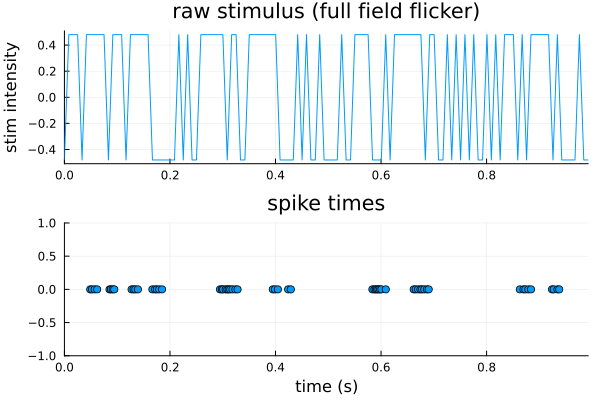

In [67]:
# Let's visualize some of the raw data
iiplot = collect(1:120)
ttplot = (iiplot .- 1) * dt_stim
spike_times_plot = spike_times[ (vec(spike_times) .>= ttplot[1]) .& (vec(spike_times) .< ttplot[end]) ]

p1 = plot(ttplot, stim[iiplot], 
    title = "raw stimulus (full field flicker)",
    ylabel = "stim intensity",
    xlims=(ttplot[1], ttplot[end]))
p2 = plot(spike_times_plot, zeros(size(spike_times_plot,1),1), 
    seriestype = :scatter, 
    title = "spike times",
    xlabel = "time (s)",
    xlims = (ttplot[1], ttplot[end]), 
    ylims = (-1,1))
p = plot(p1, p2, layout = (2,1), legend = false)
display(p)

## 3. Bin the spike train

Let us build the binned spike counts, that is, the response $Y$ that we will put into our regression as counts. For now, we will assume we want to use the same time bin size as the time bins used for the stimulus. 

**To do:**

- Compute counts in each time bin (for example, by using [StatsBase.Histogram](https://juliastats.org/StatsBase.jl/stable/empirical/)).

- Plot the counts (below the stimulus instead of the scatter plot).

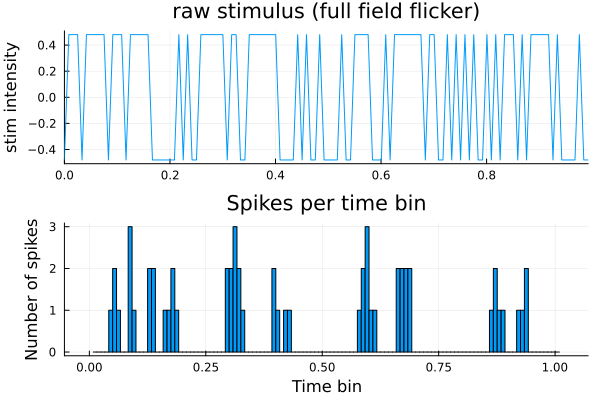

In [68]:
time_bins = collect(1:121) * dt_stim 
hist = fit(Histogram, spike_times[1:121], time_bins)

hist_plot = plot(hist,
            title = "Spikes per time bin",
            ylabel = "Number of spikes",
            xlabel = "Time bin",
            )

p1 = plot(ttplot, stim[iiplot], 
title = "raw stimulus (full field flicker)",
ylabel = "stim intensity",
xlims=(ttplot[1], ttplot[end]))

p = plot(p1, hist_plot, layout = (2,1), legend = false)

<span style="color:red">
You can also add text to interpret your results. Use colored text to make it easier for us to grade...
</span>

### Student response : 
<span style="color:red">
    In a single stimulus time bin there are up to 3 spikes in the first second. Spikes are always distributed in several times bins indicating no short burst behavior in the sample.
</span>

## 4. Build a simple GLM (without spike history, without coupling)

### 4.1. Build and vizualize the design matrix

This is a necessary step before we can fit the model: assemble a matrix
that contains the relevant regressors for each time bin of the response,
known as a design matrix $X$.  Each row of this matrix contains the relevant
stimulus chunk for predicting the spike count at a given time bin.

**To do:**

- Set the number of time bins of stimulus (`ntfilt = 25`) to use for predicting spikes. Try varying this, to see how performance changes!

- Build the design matrix. There is a slow way (building the matrix row by row), there is a fast way (exploiting the Hankel structure of the design matrix, see [ToeplitzMatrices.Hankel](https://github.com/JuliaLinearAlgebra/ToeplitzMatrices.jl)).

- Vizualize the first 50 rows of the design matrix (next to the spike count vector). See [heatmap](https://docs.juliaplots.org/stable/generated/unitfulrecipes_examples/#Heatmaps).
    ```
    heatmap(-ntfilt+1:0, 1:50, design_mat[1:50,:], yflip = true)
    ```

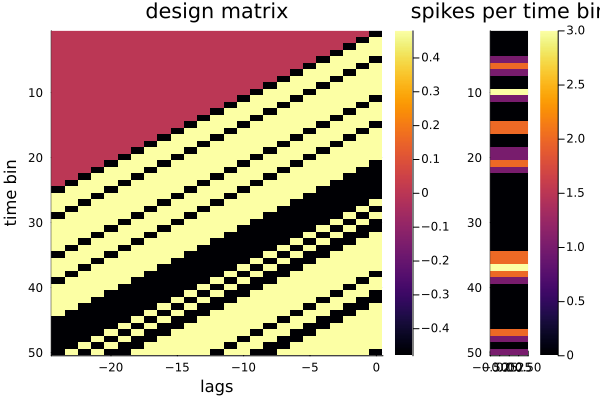

In [69]:
ntfilt = 25

design = transpose(Hankel(vcat(vec(zeros((ntfilt-1,1))),stim[1]),stim))
heat1 = heatmap(-ntfilt+1:0, 1:50, design[1:50,:], yflip = true, title = "design matrix" , xlabel = "lags" , ylabel = "time bin")

heat2 = heatmap((0:0),1:50,hist.weights[1:50,:], yflip = true , title = "spikes per time bin" )

l = @layout [a{0.8w} b]

plot(heat1,heat2,layout = l)

### 4.2. Compute and visualize the spike-triggered average (STA)

When the stimulus is Gaussian white noise, the STA provides an unbiased
estimator for the filter in a GLM / LNP model (as long as the nonlinearity
results in an STA whose expectation is not zero). It writes as 
$$\mathrm{STA} = \frac{1}{n_\mathrm{sp}} X^T Y,$$
where $n_\mathrm{sp}$ is the total number of spikes.

In many cases it's useful to visualize the STA (even if your stimuli are
not white noise), just because if we don't see any kind of structure then
this may indicate that we have a problem (e.g., a mismatch between the
design matrix and binned spike counts.

**To do:**

- Compute the STA.

- Plot the STA as a function of the time before spike.

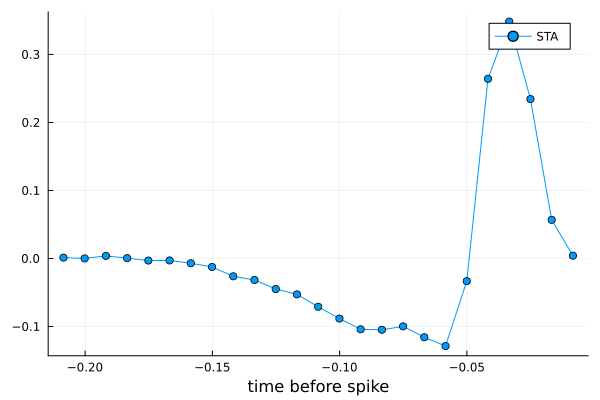

In [70]:
# ... 
time_bins = collect(1:num_time_bins+1) * dt_stim 
hist = fit(Histogram, spike_times, time_bins)

Y = hist.weights 
STA = (transpose(design) * Y) * (1/num_spikes)
plot(-(size(STA,1) :-1:1)* dt_stim , STA, markershape = :circle, label = "STA", xflip = false , xlabel = "time before spike")

### 4.3. Compute and vizualize the ML estimate of a linear-Gaussian GLM

Let us now consider a linear-Gaussian GLM, that is,
$$ y_t = k \cdot x_t + \epsilon_t \qquad \text{with} \qquad \epsilon_t \sim \mathcal{N}(0,\sigma^2).$$

The maximum-likelihood estimate for the filter $k$ of a linear-Gaussian GLM, that is, a GLM with "identity" nonlinearity and Gaussian noise (also known as least-squares regression). It writes as follows
$$\hat{k}_\mathrm{ml} = (X^T X)^{-1} X^T Y.$$

**To do:**

- Compute the ML estimate for $k$ of a linear-Gaussian GLM. 

- Plot both STA and the linear-Gaussian GLM filter (rescaled as unit vectors so we can see differences in their shape). 

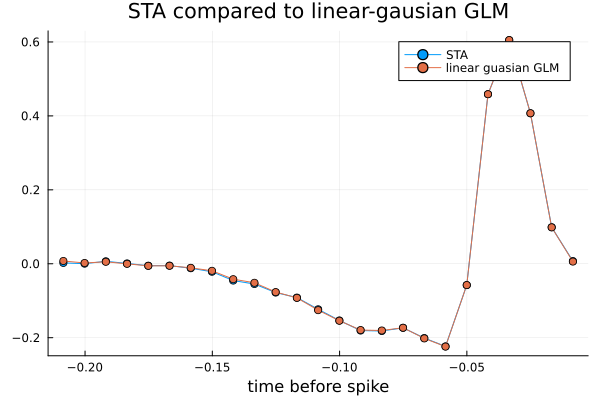

In [71]:
# ...
kml = inv(transpose(design)*design)*transpose(design)*Y
plot(-(size(STA,1) :-1:1)* dt_stim , [normalize(STA,2), normalize(kml,2)], markershape = :circle, label = ["STA" "linear guasian GLM"], xflip = false , xlabel = "time before spike", title = "STA compared to linear-gausian GLM")


### 4.4. Predicting spikes with a linear-Gaussian GLM

The ML estimate can actually be used to predict spikes because it
corresponds to a proper estimate of the model parameters (i.e., for a
Gaussian GLM). Let's inspect this "prediction".

(Prediction in quotes because we are --- for now --- looking at the performance
on training data, not test data... so it isn't really a prediction!)

**To do:**

- Compute the predicted spikes from the (estimated) linear-Gaussian GLM.

- Plot both the spike count and the "predicted" spike count.

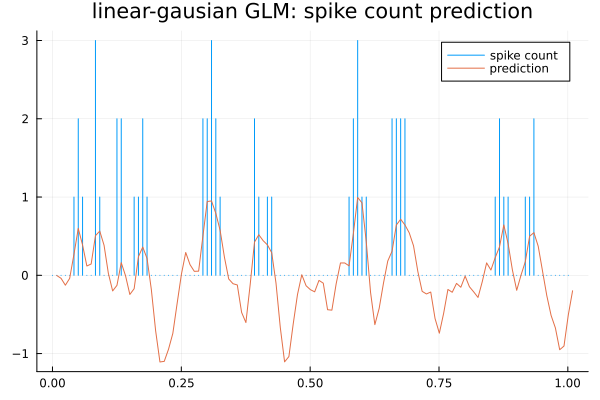

In [72]:
# ...
y_pred = design * kml


time_bins = collect(1:121) * dt_stim 
hist = fit(Histogram, spike_times[1:121], time_bins)

hist_plot = plot(hist,seriestype = :sticks,label = "spike count", title = "linear-gausian GLM: spike count prediction")
plot!(time_bins,y_pred[1:121], label = "prediction")

### 4.5. Fitting and predicting with a linear-Gaussian GLM with offset

Oops, one thing we forgot above was to include an offset or "constant"
term in the design matrix, which will allow our prediction to have
non-zero mean (since the stimulus here was normalized to have zero mean).

**To do:**

- Extend the design matrix to include a constant term (aka offset).

- Compute the ML estimate for $k$ of this linear-Gaussian GLM with offset. 

- Compute the new predicted spikes from the (estimated) linear-Gaussian GLM with offset.

- Plot the spike count, the "predicted" spike count of linear-Gaussian GLM without and with offset.

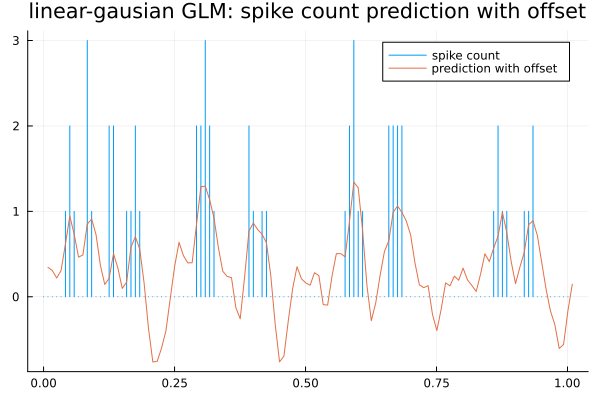

In [73]:
# ...
ntfilt = 25
time_horizon = 121
design_ext = hcat(transpose(Hankel(vcat(vec(zeros((ntfilt-1,1))),stim[1]),stim)),ones(num_time_bins)) # malke


kml_offset = inv(transpose(design_ext)*design_ext)*(transpose(design_ext)*Y)


y_pred_offset = transpose(design_ext * kml_offset)

time_bins = collect(1:time_horizon) * dt_stim 
hist = fit(Histogram, spike_times[1:time_horizon], time_bins)
hist_plot = plot(hist,seriestype = :sticks,label = "spike count", title = "linear-gausian GLM: spike count prediction with offset")
plot!(time_bins,y_pred_offset[1:time_horizon], label = "prediction with offset")


Let us compute the training error (squared prediction error on the training data), that is,
$$R^2 = 1 - \frac{SS_\mathrm{res}}{SS_\mathrm{tot}}$$
with
$$
\begin{aligned} 
    SS_\mathrm{res} & = \sum_{i=1}^n (y_i - \hat{y}_i)^2 \\
    SS_\mathrm{tot} & = \sum_{i=1}^n (y_i - \bar{y})^2, \qquad \text{with} \quad \bar{y} = \frac{1}{n} \sum_{i=1}^n y_i . 
\end{aligned}
$$

**To do:**
- Compute and print out the $R^2$ for both linear-Gaussian GLM without and with offset.

In [74]:

# without offset
SSres_no_off = sum(((Y - y_pred).^2))

y_bar = (1/length(Y)) * sum(Y)
SStot = sum((Y .- y_bar).^2)

R2_no_off = 1 - (SSres_no_off/SStot)
println("Without offset R² = ",R2_no_off)

# with offset
SSres_off = sum(((Y - transpose(y_pred_offset)).^2))

R2_off = 1 - (SSres_off/SStot)
println("With offset R² = ",R2_off)

Without offset R² = 0.1187011643191822
With offset R² = 0.3858190386344621


### 4.6. Fitting and predicting with a Poisson GLM

Let's finally move on to the LNP / Poisson GLM! That is, we consider the following model
$$
\begin{aligned}
    y_t \mid x_t & \sim \mathrm{Pois}(\lambda_t) , \\
    \lambda_t & = f(\theta \cdot x_t).
\end{aligned}$$

**To do:**

- Create a dataframe suitable to use with [GLM.jl](https://juliastats.org/GLM.jl/stable/).
    ```
    df = DataFrame(design_mat, :auto)
    df.y = spikes_binned
    ```

- Use [GLM.jl](https://juliastats.org/GLM.jl/stable/) to fit a Poisson GLM with an exponential nonlinearity. You can use the following expression for the `formula`.
    ```
    formula = Term(:y) ~ sum(Term.(Symbol.(names(df[:, Not(:y)]))))
    ```

- Compute the predicted spike rate on training data.

- Compare the filters and the predicted spike rates for the linear-Gaussian model with offset and the Poisson GLM.

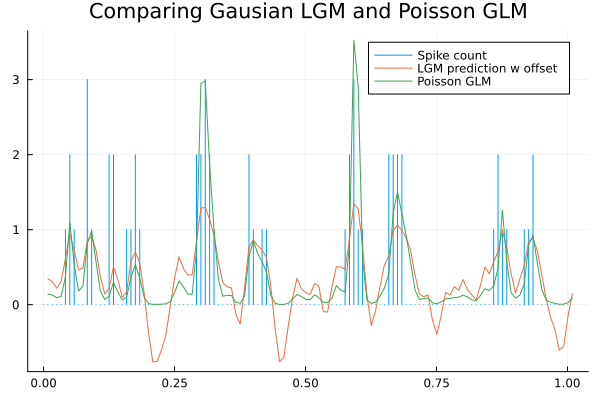

In [75]:
# ...
df = DataFrame(design, :auto)
df.y = Y

formula = Term(:y) ~ sum(Term.(Symbol.(names(df[:, Not(:y)]))))
poisson_glm = glm(formula, df, Poisson())
predictions_glm_poisson = predict(poisson_glm)

hist_plot = plot(hist,seriestype = :sticks,label = "Spike count", title = "Comparing Gausian LGM and Poisson GLM")
plot!(time_bins,y_pred_offset[1:time_horizon], label = "LGM prediction w offset")
plot!(time_bins,predictions_glm_poisson[1:121], label = "Poisson GLM")


### Student response : 
<span style="color:red">
    As it can be seen in the figure above, the poisson GLM with an exponential non-linearity fits the data much closer than the Gaussian linear model. 
</span>

## 5. Build a Poisson GLM with spike history

We will now consider a Poisson GLM with a spike rate given by
$$ \lambda_t = f(k \cdot x_t + h \cdot y_{\mathrm{hist},t}). $$


**To do:**
- Compute the binned spike counts for all four neurons.

In [76]:
#Cell 1
cell_idx = 1

spike_times = all_spike_times[cell_idx]
dt_stim = stim_times[2] - stim_times[1] # time bin size
refresh_rate = 1/dt_stim # refresh rate of the monitor
num_time_bins = size(stim, 1) # number of time bins in stimulus
num_spikes = size(spike_times, 1) # number of spikes

time_bins = collect(1:num_time_bins + 1 ) * dt_stim 
hist = fit(Histogram, spike_times, time_bins)
Y1 = hist.weights #binned spike count neuron 1

#Cell 2
cell_idx = 2

spike_times = all_spike_times[cell_idx]
dt_stim = stim_times[2] - stim_times[1] # time bin size
refresh_rate = 1/dt_stim # refresh rate of the monitor
num_time_bins = size(stim, 1) # number of time bins in stimulus
num_spikes = size(spike_times, 1) # number of spikes

time_bins = collect(1:num_time_bins + 1 ) * dt_stim 
hist = fit(Histogram, spike_times, time_bins)
Y2 = hist.weights #binned spike count neuron 2

#Cell 3
cell_idx = 3

spike_times = all_spike_times[cell_idx]
dt_stim = stim_times[2] - stim_times[1] # time bin size
refresh_rate = 1/dt_stim # refresh rate of the monitor
num_time_bins = size(stim, 1) # number of time bins in stimulus
num_spikes = size(spike_times, 1) # number of spikes

time_bins = collect(1:num_time_bins + 1 ) * dt_stim 
hist = fit(Histogram, spike_times, time_bins)
Y3 = hist.weights #binned spike count neuron 3

#Cell 4
cell_idx = 4

spike_times = all_spike_times[cell_idx]
dt_stim = stim_times[2] - stim_times[1] # time bin size
refresh_rate = 1/dt_stim # refresh rate of the monitor
num_time_bins = size(stim, 1) # number of time bins in stimulus
num_spikes = size(spike_times, 1) # number of spikes

time_bins = collect(1:num_time_bins + 1 ) * dt_stim 
hist = fit(Histogram, spike_times, time_bins)
Y4 = hist.weights #binned spike count neuron 4




144051-element Vector{Int64}:
 0
 0
 0
 0
 2
 2
 1
 0
 1
 3
 2
 0
 0
 ⋮
 2
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

### 5.1. Build design matrix: single-neuron GLM with spike-history

**To do:**
- Expand the design matrix for a single-neuron GLM with spike-history. Set the number of time bins of spike history (`nthist = 20`) to use for predicting spikes. Try varying this, to see how performance changes!

- Vizualize the design matrix.

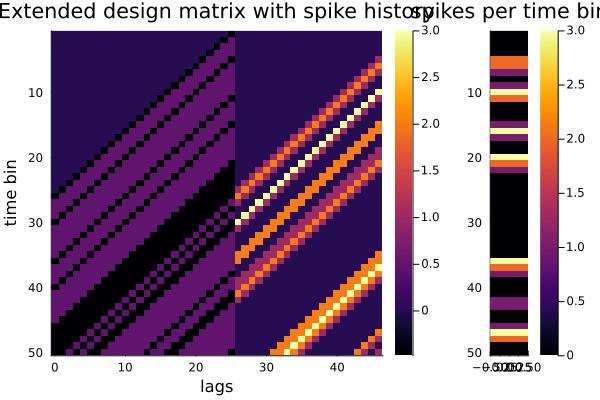

In [77]:

#neuron1 
ntfilt = 25
nthist = 20

design = transpose(Hankel(vcat(vec(zeros((ntfilt,1))),stim[1]),stim))
neuron3_hist = transpose(Hankel(vcat(vec(zeros((nthist,1))),Y3[1]),Y3))
hist_expanded_design = hcat(design,neuron3_hist)

heat_expanded = heatmap(0:ntfilt+nthist+1, 1:50, hist_expanded_design[1:50,:], yflip = true, title = "Extended design matrix with spike history" , xlabel = "lags" , ylabel = "time bin")


#heat3 = heatmap(-ntfilt+1:0, 1:50, neuron3_hist[1:50,:], yflip = true, title = "design matrix" , xlabel = "n4 spike hist" , ylabel = "time bin")

heat_spikes = heatmap((0:0),1:50,hist.weights[1:50,:], yflip = true , title = "spikes per time bin" )

l = @layout [a{0.8w} b]

plot(heat_expanded, heat_spikes , layout = l)


### 5.2. Fitting a single-neuron GLM with spike-history

**To do:**

- Fit a Poisson GLM with an exponential nonlinearity.

- Compute the predicted spike rate on training data.

- Compare the filters and the predicted spike rates for the linear-Gaussian model with offset, the Poisson GLM without spike history, and the Poisson GLM with spike history.

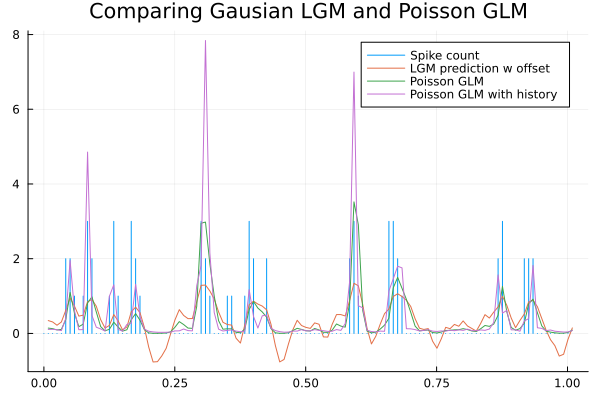

In [78]:
df = DataFrame(hist_expanded_design, :auto)
df.y = Y

formula = Term(:y) ~ sum(Term.(Symbol.(names(df[:, Not(:y)]))))
poisson_glm_hist = glm(formula, df, Poisson())
predictions_glm_poisson_hist = predict(poisson_glm_hist)

hist = fit(Histogram, spike_times[1:121], time_bins[1:121])
hist_plot = plot(hist,seriestype = :sticks,label = "Spike count", title = "Comparing Gausian LGM and Poisson GLM")
plot!(time_bins[1:121],y_pred_offset[1:121], label = "LGM prediction w offset")
plot!(time_bins[1:121],predictions_glm_poisson[1:121], label = "Poisson GLM")
plot!(time_bins[1:121],predictions_glm_poisson_hist[1:121], label = "Poisson GLM with history")

### Student response : 
<span style="color:red">
    The Poisson GLM with history follows more closely the spike count than the two other predictors. However, we can also see very high overshoots that were not present in the previous predictors which is an important source of error. 
</span>

## 6. Build a Poisson GLM for multiple-neuron responses

### 6.1. Build design matrix

**To do:**
- Expand the design matrix for a multi-neuron GLM with spike-history and coupling.

- Vizualize the design matrix.

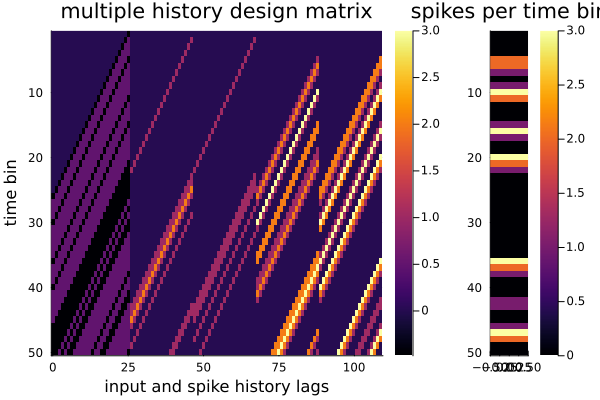

In [79]:
design = transpose(Hankel(vcat(vec(zeros((ntfilt,1))),stim[1]),stim))
#heat_design = heatmap(-ntfilt+1:0, 1:50, design[1:50,:], yflip = true, title = "design matrix" , xlabel = "lags" , ylabel = "time bin")

neuron1_hist = transpose(Hankel(vcat(vec(zeros((nthist,1))),Y1[1]),Y1))
#heat1 = heatmap(-ntfilt+1:0, 1:50, neuron1_hist[1:50,:], yflip = true, title = "design matrix" , xlabel = "n1 spike hist" , ylabel = "time bin")

neuron2_hist = transpose(Hankel(vcat(vec(zeros((nthist,1))),Y2[1]),Y2))
#heat2 = heatmap(-ntfilt+1:0, 1:50, neuron2_hist[1:50,:], yflip = true, title = "design matrix" , xlabel = "n2 spike hist" , ylabel = "time bin")

neuron3_hist = transpose(Hankel(vcat(vec(zeros((nthist,1))),Y3[1]),Y3))
#heat3 = heatmap(-ntfilt+1:0, 1:50, neuron3_hist[1:50,:], yflip = true, title = "design matrix" , xlabel = "n4 spike hist" , ylabel = "time bin")

neuron4_hist = transpose(Hankel(vcat(vec(zeros((nthist,1))),Y4[1]),Y4))
#heat4 = heatmap(-ntfilt+1:0, 1:50, neuron4_hist[1:50,:], yflip = true, title = "design matrix" , xlabel = "n4 spike hist" , ylabel = "time bin")

multy_hist_expanded_design = hcat(design,neuron1_hist,neuron2_hist,neuron3_hist,neuron4_hist)

multy_hist_heat = heatmap(0:ntfilt+(nthist*4)+4, 1:50, multy_hist_expanded_design[1:50,:], yflip = true, title = "multiple history design matrix" , xlabel = "input and spike history lags" , ylabel = "time bin")

heat_spikes = heatmap((0:0),1:50,hist.weights[1:50,:], yflip = true , title = "spikes per time bin" )

l = @layout [a{0.8w} b]

plot(multy_hist_heat, heat_spikes , layout = l)


### 6.2. Fit GLM

**To do:**

- Fit a Poisson GLM with an exponential nonlinearity with spike history and coupling.

- Compute the predicted spike rate on training data.

- Compare the filters and the predicted spike rates for the Poisson GLM without spike history, the Poisson GLM with spike history, and the Poisson GLM with spike history and coupling.

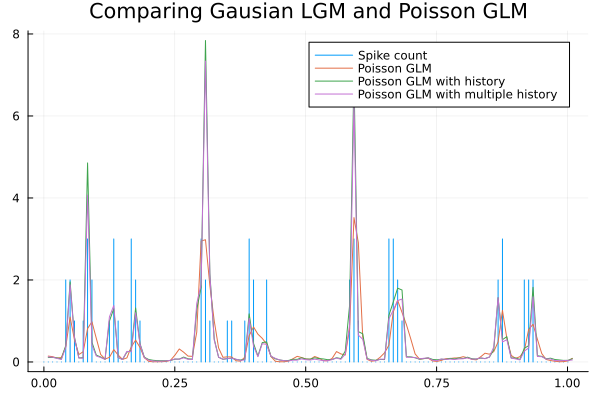

In [80]:
df = DataFrame(multy_hist_expanded_design, :auto)
df.y = Y

formula = Term(:y) ~ sum(Term.(Symbol.(names(df[:, Not(:y)]))))
poisson_glm_multy_hist = glm(formula, df, Poisson())
predictions_glm_poisson_multy_hist = predict(poisson_glm_multy_hist)

hist = fit(Histogram, spike_times[1:121], time_bins[1:121])
hist_plot = plot(hist,seriestype = :sticks,label = "Spike count", title = "Comparing Gausian LGM and Poisson GLM")
plot!(time_bins[1:121],predictions_glm_poisson[1:121], label = "Poisson GLM")
plot!(time_bins[1:121],predictions_glm_poisson_hist[1:121], label = "Poisson GLM with history")
plot!(time_bins[1:121],predictions_glm_poisson_multy_hist[1:121], label = "Poisson GLM with multiple history")


### Student response : 
<span style="color:red">
    Adding the other neurons history and coupling improves again the prediction. This improvement is qualitatively smaller than the previous one however, it mainly reduces the overshoots that were seen with a single neuron history.  
</span>

## 7. Model comparison: log-likelihoood and AIC

Let's compute log-likelihood (the higher the better) and AIC (the smaller the better) to see how
much we gain by adding each of these filter types in turn.

The AIC is defined as 
$$\mathrm{AIC} = 2 k - \log p(\mathbf{y} \mid \mathbf{x}, \hat{\theta}),$$
where $k$ is the number of estimated parameters in the model.

**To do:**

- Compute the log-likelihood and the AIC for the Poisson GLM without spike history, with spike history, and with spike history and coupling.

In [86]:
# wihout spike history 

coeffs = coef(poisson_glm)
k = length(coef(poisson_glm))
log_lik = loglikelihood(poisson_glm)
println("Log likelihood for poisson GLM with exp non linearity : ", log_lik)
AIC = 2k - log_lik
println("AIC for poisson GLM with exp non linearity : ", AIC)

#with spike history

coeffs = coef(poisson_glm_hist)
k = length(coef(poisson_glm_hist))
log_lik = loglikelihood(poisson_glm_hist)
println("Log likelihood for poisson GLM with exp non linearity and spike history: ", log_lik)
AIC = 2k - log_lik
println("AIC for poisson GLM with exp non linearity and spike history: ", AIC)

#with spike history and coupling

coeffs = coef(poisson_glm_multy_hist)
k = length(coef(poisson_glm_multy_hist))
log_lik = loglikelihood(poisson_glm_multy_hist)
println("Log likelihood for poisson GLM with exp non linearity and multiple spike history : ", log_lik)
AIC = 2k - log_lik
println("AIC for poisson GLM with exp non linearity and multiple spike history: ", AIC)


Log likelihood for poisson GLM with exp non linearity : -75269.35542242114
AIC for poisson GLM with exp non linearity : 75321.35542242114
Log likelihood for poisson GLM with exp non linearity and spike history: -58368.305689345965
AIC for poisson GLM with exp non linearity and spike history: 58464.305689345965
Log likelihood for poisson GLM with exp non linearity and multiple spike history : -58009.972371818
AIC for poisson GLM with exp non linearity and multiple spike history: 58231.972371818
